# Задание 1. A/B–тестирование

### Условие 
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Входные данные

В качестве входных данных Мы имеем 4 csv-файла:

__groups.csv__ - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

__groups_add.csv__ - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных.

__active_studs.csv__ - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.

__checks.csv__ - файл с информацией об оплатах пользователей в дни проведения эксперимента. 


---

In [1]:
#Импортируем нужные нам библиотеки

import pandas as pd
import requests
from   urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from   scipy import stats
from   scipy.stats import norm, chi2_contingency, mannwhitneyu
import pandahouse as ph
import warnings
from tqdm.auto import tqdm

In [2]:
# отключаем предупреждения

warnings.filterwarnings('ignore')

In [3]:
# добавим стиля графикам

sns.set(
    font_scale=1.5,
    style="darkgrid",
    rc={'figure.figsize':(9,5)}
        )

---

In [4]:
#Функция для чтения файлов с Яндекс Диска

def get_files(url):
    base_url  = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=url))
    response  = requests.get(final_url)
    href      = response.json()['href']

In [5]:
# Применяем функцию для чтения файлов с яндекс диска, если не получится их получить,
# то прочитаем данные с локальной директории

try:
    groups        = pd.read_csv(get_files('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep = ';')
    groups_add    = pd.read_csv(get_files('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'))
    active_studs  = pd.read_csv(get_files('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))
    checks        = pd.read_csv(get_files('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep = ';')
except:
    groups        = pd.read_csv('~/final_project_data/Проект_2_groups.csv', sep = ';')
    groups_add    = pd.read_csv('~/final_project_data/Проект_2_group_add.csv')
    active_studs  = pd.read_csv('~/final_project_data/Проект_2_active_studs.csv')
    checks        = pd.read_csv('~/final_project_data/Проект_2_checks.csv', sep = ';')

In [6]:
#создаем функцию для просмотра информации о датафрейме

def view_data(df):
    # Просмотр первых 5 строк датафрейма
    print('Head:')
    print(df.head())
    print()
    
    # Просмотр общей информации о датафрейме
    print('\nКоличество строк и колонок:')
    print(df.shape)
    print()
    
    # Типы данных
    print('\nТипы данных:')
    print(df.dtypes)
    print()

    # Есть ли пропущенные значения 
    print('\nПропущенные значения:')
    print(df.isna().sum())
    print()
    
    # Ищем дубликаты
    print('\nКоличество дубликатов:')
    print(df.duplicated().sum())
    

__groups__ - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе
(А – контроль, B – целевая группа)

In [7]:
view_data(groups)

Head:
     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A


Количество строк и колонок:
(74484, 2)


Типы данных:
id      int64
grp    object
dtype: object


Пропущенные значения:
id     0
grp    0
dtype: int64


Количество дубликатов:
0


In [8]:
groups.grp.value_counts()

B    59813
A    14671
Name: grp, dtype: int64

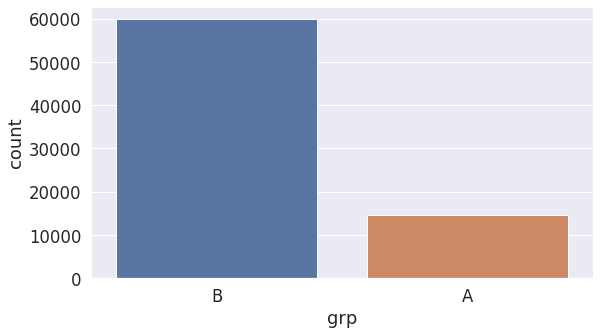

In [9]:
sns.countplot(groups.grp);

__groups_add__ - дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных

In [10]:
view_data(groups_add)

Head:
        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B


Количество строк и колонок:
(92, 2)


Типы данных:
id      int64
grp    object
dtype: object


Пропущенные значения:
id     0
grp    0
dtype: int64


Количество дубликатов:
0


In [11]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

In [12]:
full_groups = pd.concat([groups, groups_add], axis=0) #соеденим датафреймы 

In [13]:
#проверка

len(groups)+len(groups_add)==len(full_groups) 

True

In [14]:
view_data(full_groups)

Head:
     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A


Количество строк и колонок:
(74576, 2)


Типы данных:
id      int64
grp    object
dtype: object


Пропущенные значения:
id     0
grp    0
dtype: int64


Количество дубликатов:
0


__active_studs__ - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [15]:
view_data(active_studs)

Head:
   student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369


Количество строк и колонок:
(8341, 1)


Типы данных:
student_id    int64
dtype: object


Пропущенные значения:
student_id    0
dtype: int64


Количество дубликатов:
0


In [16]:
print(str(round(active_studs.shape[0] / full_groups.shape[0] * 100, 2)) \
                 + '% пользователей посетили сайт во время эксперимента')

11.18% пользователей посетили сайт во время эксперимента


__checks__ - файл с информацией об оплатах пользователей в дни проведения эксперимента

In [17]:
view_data(checks) 

Head:
   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0


Количество строк и колонок:
(541, 2)


Типы данных:
student_id      int64
rev           float64
dtype: object


Пропущенные значения:
student_id    0
rev           0
dtype: int64


Количество дубликатов:
0


In [18]:
#переименуем колонки 

active_studs.columns = ['id']
checks.columns       = ['id', 'revenue']

In [19]:
# Пользователи оплатившие покупки, не все заходили на сайт 

checks.shape[0] - checks.merge(active_studs, on='id').shape[0]

149

In [20]:
#проверим содержаться ли они в списке active_studs

pay_on_site = checks.merge(active_studs, on='id')

In [21]:
#пользователи совершившие покупки, но не заходившие на сайт

not_pay_on_site = checks.query('id not in @pay_on_site.id')

In [22]:
# отлично, пользователи совершившие покупку не учитываются
# как зашедшием на платформу в дни проведения эксперимента. 

len(active_studs.query('id in @not_pay_on_site.id'))

0

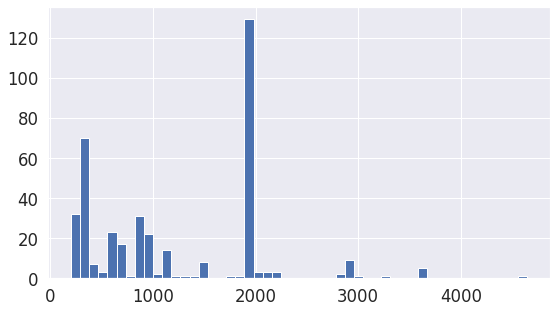

In [23]:
pay_on_site.revenue.hist(bins=50);

In [24]:
pay_on_site.revenue.value_counts().reset_index().rename(columns={'index':'revenue', 'revenue':'count'}).head(10)

,revenue,count
0,1900.0000,93
1,290.0000,70
2,1900.0001,35
3,199.0000,32
4,840.0000,24
5,990.0000,22
6,690.0000,17
7,580.0000,11
8,590.0000,11
9,1140.0000,11


Среди пользователей совершивших покупку на сайте наблюдается множество чеков с revenue 1900 и 1900.0001. Что это сказать трудно, так как мы не знаем происхождения данных. Возможно, это выбросы.. Возможно по этой цене продавался акционный товар, например 'футболка' или, если мы школа онлайн образования, то это покупка нашего самого популярного курса. Можно предположить, что чеки чо значением 1900 доставлялись в пункт выдачи, а чеки с 1900.0001 курьером на дом. Или же от 1900 это минимальная сумма заказа для бесплатной доставки и тд. Разнообразных гипотез можно выдвинуть много... Далее, после объединения таблиц, мы определим к какой группе пользователей (целевой или контрольной) относятся такие чеки

In [25]:
#cоеденим все в итоговый датафрейм с которым уже можно работать
#(остались только пользователи посетившие сайт во время эксперимента)

df = active_studs.merge(full_groups, how='left', on='id').merge(pay_on_site, how='left', on='id')
                                                        #.merge(checks, how='left', on='id') можно было итак,
                                                        # т.к. останутся все равно только пользователи, которые
                                                        # точно заходили на сайт, но я укажу явно 

In [26]:
df = df.rename(columns={'grp':'group'}).fillna(0) #переименуем колонку и избавимся от всех NaN

In [27]:
view_data(df)

Head:
        id group  revenue
0   581585     A      0.0
1  5723133     A      0.0
2  3276743     B      0.0
3  4238589     A      0.0
4  4475369     B      0.0


Количество строк и колонок:
(8341, 3)


Типы данных:
id           int64
group       object
revenue    float64
dtype: object


Пропущенные значения:
id         0
group      0
revenue    0
dtype: int64


Количество дубликатов:
0


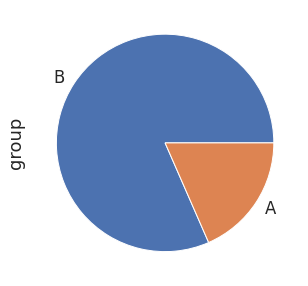

In [28]:
#в целевой группе данных в несколько раз больше

df.group.value_counts().plot.pie();

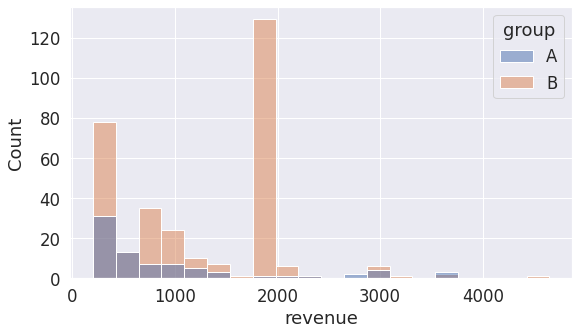

In [29]:
sns.histplot(data=df[df.revenue > 0], x ='revenue', hue ='group', bins=20);

Выше уже отмечалось, что в районе 1900 имеется множество чеков, как оказалось они пренадлежат к целевой группе. Что это сказать все еще трудно. 

In [30]:
#добавим колонку с фактом оплаты. Она определенно нам понадобится в последующем 

df['purchase'] = df.revenue.apply(lambda x: 0 if x==0 else 1)

In [31]:
df[df.purchase > 0].shape[0] == pay_on_site.shape[0] #проверка 

True

In [32]:
df.head()

,id,group,revenue,purchase
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0


----

#### Вопросы


- На какие метрики Вы смотрите в ходе анализа и почему?

- Имеются ли различия в показателях и с чем они могут быть связаны?

- Являются ли эти различия статистически значимыми?

- Стоит ли запускать новую механику на всех пользователей?


предлагаю рассмотреть следующие метрики:
1. __CR__ (conversion rate) - конверсия или отношение числа пользователей совершившиех покупку к общему числу пользователей

2. __ARPPU__ (Average revenue per paying user) - средний доход с платящего пользователя

3. __APRU__ (Average revenue per user) - средний доход на одного пользователя среди всех пользователей


На основе имеющихся данных это те метрики, которые мы можем оценить и они наиболее развернуто отразят результы проведенного a/b теста

Основной метрикой будем считать __CR__, она отразит результат нашей гипотезы, напомню, что в ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 

In [33]:
#сгруппирум по группам, посчитаем количество id и сумму покупок

stat = df.groupby('group', as_index=False) \
    .agg({'id':'count', 'revenue':'sum', 'purchase':'sum'})

In [34]:
stat.columns = ['group', 'id_count', 'sum_revenue', 'sum_purchase'] #переименуем колонки

In [35]:
#посчитаем метрики

stat['CR']    = round(stat.sum_purchase/stat.id_count * 100, 2)
stat['ARPPU'] = round(stat.sum_revenue/stat.sum_purchase, 2)
stat['ARPU']  = round(stat.sum_revenue/stat.id_count, 2)

In [36]:
stat

,group,id_count,sum_revenue,sum_purchase,CR,ARPPU,ARPU
0,A,1538,72820.0000,78,5.07,933.59,47.35
1,B,6803,394974.0035,314,4.62,1257.88,58.06


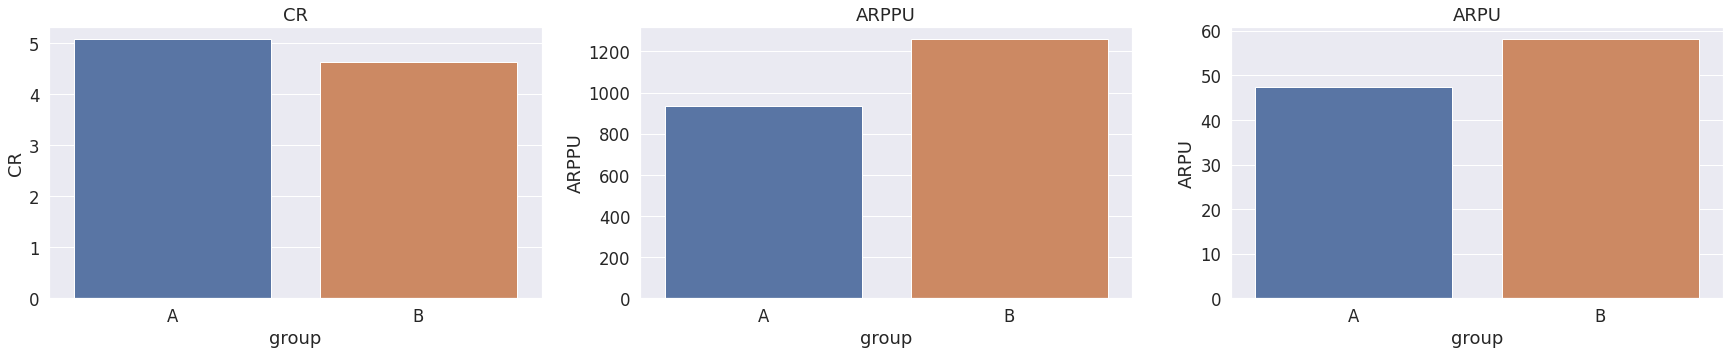

In [37]:
# создание подграфиков
fig, axs = plt.subplots(1, 3, figsize=(30, 5))

# построение столбчатых диаграмм с помощью sns.barplot()
sns.barplot(data=stat, x='group', y='CR', ax=axs[0])
axs[0].set_title('CR')
sns.barplot(data=stat, x='group', y='ARPPU', ax=axs[1])
axs[1].set_title('ARPPU')
sns.barplot(data=stat, x='group', y='ARPU', ax=axs[2])
axs[2].set_title('ARPU')

plt.show()


На графиках видно, что конверсия упала, а средний доход вырос. Перед нами стоит вопром являются ли эти различия статистически значимыми и стоит ли вообще запускать новую механику на всех пользователей?



#### Гипотезы для измеряемых метрик
- Нулевая гипотеза (H0) - изменений в сравниваемых группах нет 
- Альтернативня гипотеза (H1) - имеются статистически значимымые изменения

проверим распределения на нормальность. Это можно сделать с помощью гистограммы, если она будет выглядеть
нормально, то подтвердим нормальность с помощью теста Шапиро-Уилка

In [38]:
#для начала разделим контрольную и целевую группу


control = df[df.group == 'A']
test   = df[df.group == 'B']


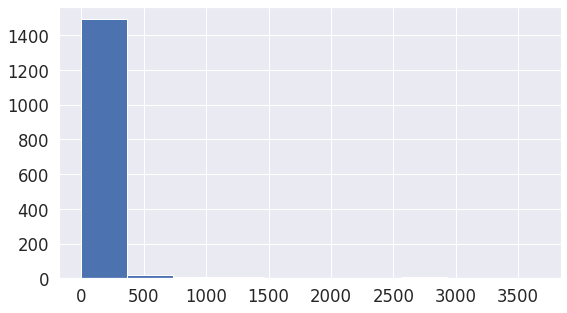

In [39]:
control.revenue.hist();

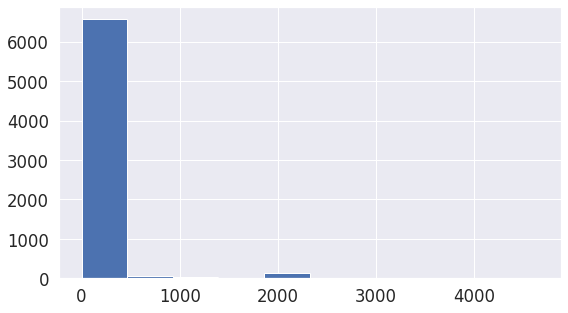

In [40]:
test.revenue.hist();

как мы видим и без теста Шапиро-Уилка распределения не нормальны

### Проверим различия в конверсиях CR

Так как сравниваемые группы имееют категориальную величину воспользуемся Критерием Хи-квадрат (или критерий согласия Пирсона)

Критерий Хи-квадрат используется для проверки гипотезы о том, что две группы имеют одинаковые распределения для определенной категориальной переменной. Он работает путем сравнения наблюдаемых частот категорий в каждой выборке с ожидаемыми частотами, которые могут быть рассчитаны на основе гипотезы о равных распределениях

In [41]:
df.head()

,id,group,revenue,purchase
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0


In [42]:
# выполняем хи-квадрат тест
table = pd.crosstab(df.group, df.purchase) #таблица сопряженности
chi2, pval, dof, expected = chi2_contingency(table)  #применяем функцию из модуля scipy.stats

# выводим результаты
print('Хи-квадрат статистика: ', chi2)
print('p-значение: ', pval)
print()
print()
if pval > 0.05:
    print(f'p-value {round(pval, 3)} > 0.05, принимаем нулевую гипотезу (конверсии статистически значимо не отличаются)')
else:
    print(f'p-value {round(pval, 3)} < 0.05, принимаем альтернативную гипотезу (конверсии отличаются статистически значимо)')

Хи-квадрат статистика:  0.48480826522557896
p-значение:  0.48625240457231045


p-value 0.486 > 0.05, принимаем нулевую гипотезу (конверсии статистически значимо не отличаются)


### Сравним ARPPU

Для сравнения ARPPU и ARPU будем использовать Bootstrap. T-test не подойдет, так как распределения не имееют нормального вида. Критерий Манна-Уитни не стоит использовать так как есть множество значений в районе 1900

In [43]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [44]:
test_list_1 = test[test.purchase == 1].revenue

In [45]:
control_list_1 = control[control.purchase == 1].revenue

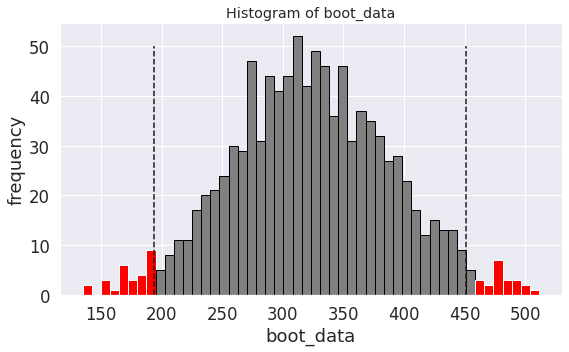

In [46]:
booted_data = get_bootstrap(test_list_1, control_list_1); #применяем бутстрэп

In [47]:
booted_data["p_value"] # альфа

8.101009119983694e-07

In [48]:
booted_data["quants"] # ДИ

,0
0.025,193.537510
0.975,451.243245


По результатам теста принимаем альтернативную гипотезу. p-value гораздо ниже уровня значимости 0.05, что говорит об значимых статистических изменениях в среднем доходе от платящего пользователя

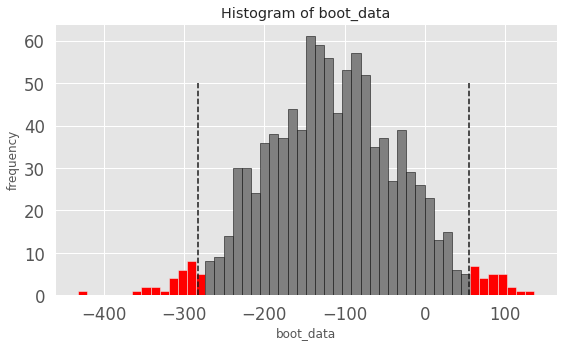

0.17194660169194076
0.5453040743963742


In [49]:
#Ради только интереса проведем тест на сравниваемые группы без чеков с суммой 1900

_ = test.query('revenue != "1900" and revenue != "1900.0001" and purchase == 1').revenue

booted_data = get_bootstrap(_, control_list_1)

print(booted_data["p_value"]) # альфа
print(mannwhitneyu(_, control_list_1)[1])

Бутсрэп и критерий Манна-Уитни в этом случае говорят, что статистически значимых изменений нет

### Сравним ARPU

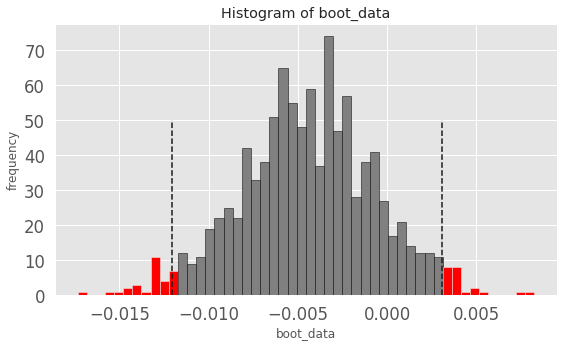

In [50]:
booted_data = get_bootstrap(test.purchase, control.purchase); #применяем бутсрэп

In [51]:
booted_data["p_value"] # альфа

0.23556871600694906

In [52]:
booted_data["quants"] # ДИ

,0
0.025,-0.012057
0.975,0.003087


In [53]:
f'P-value равен {round(booted_data["p_value"], 2)}. Средний чек среди всех пользователей значимо не различился. Принимаем нулевую гипотезу'

'P-value равен 0.24. Средний чек среди всех пользователей значимо не различился. Принимаем нулевую гипотезу'

### Вывод
1. Новая механика статистически значимо не повлияла на Конверсию в покупку при использовании сайта;
2. ARPPU значимо вырос, но могло ли изменение механики оплаты на сайте повлиять на это? Возможно, параллельно проводились и другие A/B тесты. Например, была запущенна какая-либо акция при покупках на большие чеки (повышенные бонусы, подарок к покупке и тд)
3. Измений в ARPU статистически значимых нет.
#### Новую механику оплаты на сайте запускать пока что не нужно. Конверсия не стат значимо, но  упала. Почему вырос ARPPU? Это нужно будет проанализировать в отдельном тесте, новая механика оплаты вряд ли могла повлиять на ее рост. Так же обратим в очередной раз внимание  на чеки 1900, которые похожи на выбросы,  без них, стат значимых изменений не было бы. 


____

___

# Задание 2. SQL

### 2.1 Очень усердные ученики.

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

_Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц._

In [54]:
#подключаемсся к ClickHouse

connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student',
                  password='dpo_python_2020')

In [55]:
#посмотрим на таблицу default.peas

query = '''
    SELECT
        st_id,
        toDateTime(timest) as timest,
        correct,
        subject
    FROM default.peas
    LIMIT 5
'''

peas = ph.read_clickhouse(query, connection=connection) #получаем данные из clickhouse в pandas dataframe
peas

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


In [56]:
query = '''
SELECT count(st_id) count_diligent_student
FROM
    (  
    SELECT
        DISTINCT(st_id),
        sum(correct) sum_correct
    FROM default.peas
    GROUP by st_id
    HAVING sum_correct >= 20
    )
'''

count_diligent_student = ph.read_clickhouse(query, connection=connection) #получаем данные из clickhouse в pandas dataframe
count_diligent_student

,count_diligent_student
0,136


In [57]:
print(f'Количество очень усердных студентов - {count_diligent_student.count_diligent_student[0]}')

Количество очень усердных студентов - 136


---

### 2.2 Оптимизация воронки

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### Задача
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

__ARPU__

__ARPAU__

__CR__ в покупку 

__СR__ активного пользователя в покупку 

__CR__ пользователя из активности по математике (subject = ’math’) в покупку курса по математике

__ARPU__ считается относительно всех пользователей, попавших в группы.


Активным считается пользователь, за все время решивший больше __10__ задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший __2__ или больше задач правильно по математике.

дано три таблицы __*default.peas, default.studs и default.final_project_check*__ для начала посмотрим на них

In [58]:
peas

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


In [59]:
query = '''
    SELECT *
    FROM default.studs
    LIMIT 5
'''

studs = ph.read_clickhouse(query, connection=connection) #получаем данные из clickhouse в pandas dataframe
studs

,st_id,test_grp
0,100379,pilot
1,101432,control
2,104818,pilot
3,104885,pilot
4,104966,pilot


In [60]:
query = '''
    SELECT
        st_id,
        toDateTime(sale_time) sale_time,
        money,
        subject
    FROM default.final_project_check
    LIMIT 5
'''

final_project_check = ph.read_clickhouse(query, connection=connection) 
final_project_check

,st_id,sale_time,money,subject
0,101432,2021-10-31 04:44:32,85000,Math
1,101432,2021-10-31 12:43:50,65000,Vizualization
2,104885,2021-10-30 17:05:55,65000,Vizualization
3,104885,2021-10-30 22:49:33,75000,Statistics
4,106464,2021-10-31 13:17:13,85000,Math


In [61]:
query = '''
    SELECT 
        b.test_grp as group,
        SUM(c.money) / COUNT(DISTINCT(b.st_id)) ARPU,
        SUM(CASE WHEN a.sum_correct > 10 THEN c.money END) / COUNT(DISTINCT(CASE WHEN a.sum_correct > 10 THEN b.st_id END)) ARPAU,
        COUNT(DISTINCT CASE WHEN c.money != 0 THEN c.st_id END) / COUNT(DISTINCT b.st_id) * 100 CR_percent,
        COUNT(DISTINCT CASE WHEN a.sum_correct > 10 and c.money != 0  THEN b.st_id END) / COUNT(DISTINCT CASE WHEN a.sum_correct > 10 THEN b.st_id END) * 100 CR_active_percent,
        COUNT(DISTINCT CASE WHEN c.subject = 'Math' and a.sum_math_correct >= 2 and c.money != 0  THEN b.st_id END) / COUNT(DISTINCT CASE WHEN a.sum_math_correct >= 2 THEN b.st_id END) * 100 CR_active_math_percent
    FROM
        (SELECT
            DISTINCT(st_id) st_id,
            sum(correct) sum_correct,
            sum(CASE WHEN subject == 'Math' THEN correct END) sum_math_correct
        FROM
            default.peas
        GROUP BY st_id
        ) a
    FULL JOIN default.studs as b ON a.st_id=b.st_id
    FULL JOIN default.final_project_check as c ON b.st_id=c.st_id
    GROUP BY group
    '''

SQL_result = ph.read_clickhouse(query, connection=connection) 
SQL_result

,group,ARPU,ARPAU,CR_percent,CR_active_percent,CR_active_math_percent
0,control,4540.983607,10393.700787,4.918033,11.023622,6.122449
1,pilot,11508.474576,29739.583333,10.847458,26.041667,9.523810


___

___

## Задание 3. Python
### Задача 1

__Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.__

In [62]:
def update_group_add(url, groups, active_studs, checks):    
    try:
        groups_add = pd.read_csv(get_files('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'))
    except:
        groups_add    = pd.read_csv('~/final_project_data/Проект_2_group_add.csv')
    groups_add.rename(columns={groups_add.columns[0]: 'id', groups_add.columns[0]: 'grp'})
    full_groups = pd.concat([groups, groups_add], axis=0) #соеденим датафреймы 
    df = active_studs.merge(full_groups, how='left', on='id').merge(checks, how='left', on='id')
    df = df.rename(columns={'grp':'group'}).fillna(0) #переименуем колонку и избавимся от всех NaN
    df['purchase'] = df.revenue.apply(lambda x: 0 if x==0 else 1)
    stat = df.groupby('group', as_index=False).agg({'id':'count', 'revenue':'sum', 'purchase':'sum'})
    stat.columns = ['group', 'id_count', 'sum_revenue', 'sum_purchase']
    stat['CR']    = round(stat.sum_purchase/stat.id_count * 100, 2)
    stat['ARPPU'] = round(stat.sum_revenue/stat.sum_purchase, 2)
    stat['ARPU']  = round(stat.sum_revenue/stat.id_count, 2)
    
    return stat
                                                       

In [63]:
update_group_add(groups_add, groups, active_studs, checks)

,group,id_count,sum_revenue,sum_purchase,CR,ARPPU,ARPU
0,A,1538,72820.0000,78,5.07,933.59,47.35
1,B,6803,394974.0035,314,4.62,1257.88,58.06


### Задача 2
__Реализуйте функцию, которая будет строить графики по получаемым метрикам.__

In [64]:
def vizualization(data):
    fig, axs = plt.subplots(1, 3, figsize=(30, 5))
    sns.barplot(data=stat, x='group', y='CR', ax=axs[0])
    axs[0].set_title('CR')
    sns.barplot(data=stat, x='group', y='ARPPU', ax=axs[1])
    axs[1].set_title('ARPPU')
    sns.barplot(data=stat, x='group', y='ARPU', ax=axs[2])
    axs[2].set_title('ARPU')
    return

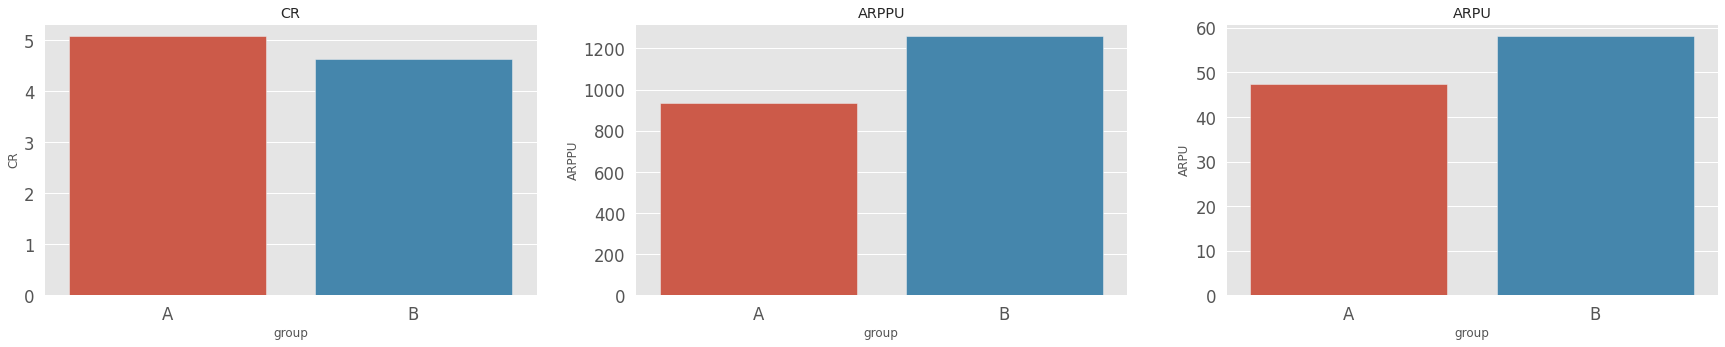

In [65]:
vizualization(stat)